# Summary statistics of coastal change for African countries

* **Products used:** [DE Africa Coastlines]()



## Description

The rate of change points augmented with country (level 0) and province (level 1) labels will be used to generate continental scale statistics.

In [1]:
import os
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import numpy as np
from shapely.ops import nearest_points

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from datacube.utils.geometry import Geometry
from coastlines.vector import change_regress

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import datacube 

## Load augmented rate of change

Only `good` rate of change measurements have been kept.
Admin boundary labels have been matched with the following code.

```
gadm_africa  = gpd.read_file("~/dev/data/gadm_africa.gpkg")
gadm_level1 = gadm_africa.dissolve(by=f"GID_1")
gadm_level1 = gadm_level1.to_crs(coastlines.crs)
gadm_level1.reset_index(inplace=True)

# match coastlines to admin region geometries
coastlines = coastlines.sjoin_nearest(gadm_level1[["GID_0", "NAME_0", "GID_1", "NAME_1","geometry"]], how="left", max_distance=1000, distance_col="GID_1_dist")
coastlines = coastlines.drop(columns=["index_right"])

```

In [ ]:
# coastlines version, v0.4.0(-2022) or v0.4.2 (-2023)
version = 'v0.4.2'

In [2]:
%%time
coastlines = gpd.read_file(f"../data/coastlineschange_{version}_gadm_level1.gpkg")

CPU times: user 17min 10s, sys: 9.87 s, total: 17min 20s
Wall time: 18min 12s


In [3]:
coastlines.head()

,index,uid,rate_time,sig_time,se_time,outl_time,dist_2000,dist_2001,dist_2002,dist_2003,...,nsm,max_year,min_year,country,certainty,GID_0,NAME_0,GID_1,NAME_1,geometry
0,0,sv0e5jprxn,-0.19,0.004,0.06,2016 2018 2019,3.11,1.34,1.79,1.55,...,-3.11,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3337964.536 3511650.480)
1,1,sv0e5jr8u3,-0.33,0.013,0.12,2019,3.08,0.94,1.69,0.74,...,-3.08,2000,2018,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3337985.922 3511671.507)
2,2,sv0e5jrcce,-0.30,0.105,0.17,NaN,2.46,-0.39,0.97,-0.46,...,-2.46,2000,2019,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338007.608 3511692.203)
3,3,sv0e5jrfyy,-0.04,0.444,0.05,NaN,2.33,0.27,0.25,-0.92,...,-2.33,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338029.177 3511713.014)
4,4,sv0e5m2h5c,-0.04,0.282,0.04,NaN,2.55,1.20,0.71,0.26,...,-2.55,2000,2010,Egypt,good,EGY,Egypt,EGY.22_1,Janub Sina',POINT (3338050.593 3511734.009)


## Summarize exposure for each country

In [4]:
countries = coastlines.NAME_0.unique()
countries = [c for c in countries if str(c)!='nan' and (c!='Spain')]

In [5]:
countries_summary = pd.DataFrame(countries, columns=["Country"])
countries_summary[['pop_nearshore', 'pop_nearerosion', 'pop_lowelev', 'pop_valley']] = [np.nan]*4

In [6]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"
# Load population data
ds = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', 
                       chunks ={'x': 2000, 'y': 2000})
ds = ds.rename({'x':'longitude','y':'latitude'})

# Load elevation data
dc=datacube.Datacube()
mrvbf = dc.load(product="dem_srtm_deriv", measurements=["mrvbf"], dask_chunks={'longitude':2000, 'latitude':2000}, 
                like=ds.geobox).mrvbf.squeeze()
elev = dc.load(product="dem_srtm", measurements=["elevation"], dask_chunks={'longitude':2000, 'latitude':2000}, 
                like=ds.geobox).elevation.squeeze()

In [8]:
%%time

for idx in countries_summary.index:
    good_rates = coastlines[coastlines[f"NAME_0"]==countries_summary.loc[idx][f"Country"]]
    if len(good_rates)==0:
        print("no data over", countries_summary.loc[idx][f"Country"])
        continue
    else:
        print(countries_summary.loc[idx][f"Country"])

    os.environ['AWS_DEFAULT_REGION']="us-east-1"
    os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"
    buffered = good_rates.copy()
    buffer=1000
    buffered['geometry'] = buffered.to_crs('6933').buffer(buffer).to_crs(ds.geobox.crs)
    coast_bbox = buffered.unary_union.bounds
    pop_raster = ds.isel(band=0).sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))
    shoreline_mask = xr_rasterize(gdf=buffered,
                                da=pop_raster,
                                transform=pop_raster.geobox.transform,
                                crs=pop_raster.geobox.crs)
    pop_nearshore = (pop_raster*shoreline_mask).sum().compute().data.round().astype(int)
    print("Population within 1km of 2021 shoreline:", pop_nearshore)

    buffered = good_rates[(good_rates.sig_time<0.01) & (good_rates.rate_time<-0.5)].copy()
    buffer=1000
    buffered['geometry'] = buffered.to_crs('6933').buffer(buffer).to_crs(ds.geobox.crs)
    hotspots_mask = xr_rasterize(gdf=buffered,
                                da=pop_raster,
                                transform=pop_raster.geobox.transform,
                                crs=pop_raster.geobox.crs)
    pop_nearerosion = (pop_raster*hotspots_mask).sum().compute().data.round().astype(int)
    print("Population within 1km of shoreline retreating at more than 0.5 meters per year:", pop_nearerosion)

    os.environ['AWS_DEFAULT_REGION']="af-south-1"
    os.environ['AWS_S3_ENDPOINT']="s3.af-south-1.amazonaws.com"
    elev_mask = elev.sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))<5
    pop_lowelev = (pop_raster*hotspots_mask*elev_mask).sum().compute().data.round().astype(int)
    print("Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters:", 
      pop_lowelev)
    
    mrvbf_mask = mrvbf.sel(longitude=slice(coast_bbox[0],coast_bbox[2]), latitude = slice(coast_bbox[3], coast_bbox[1]))==7
    pop_valley = (pop_raster*hotspots_mask*mrvbf_mask).sum().compute().data.round().astype(int)
    print("Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom):", 
      pop_valley)
    if (pop_valley > 0) and not (os.path.exists(f'{countries_summary.loc[idx][f"Country"]}_hotspots.geojson')):
        hotspots_map = pop_raster*hotspots_mask*mrvbf_mask
        exposure_vectors = xr_vectorize(hotspots_map, mask=hotspots_map > 0, attribute_col='population', crs='epsg:4326',
                                        export_shp=f'{countries_summary.loc[idx][f"Country"]}_hotspots.geojson')
        del hotspots_map, exposure_vectors
    
    for cname in ['pop_nearshore', 'pop_nearerosion', 'pop_lowelev', 'pop_valley']:
        countries_summary.at[idx, cname] = eval(cname)
    #print(countries_summary.loc[idx][['pop_nearshore', 'pop_nearerosion', 'pop_lowelev', 'pop_valley']])
        
    del pop_raster, shoreline_mask, hotspots_mask, elev_mask, mrvbf_mask

Egypt
Population within 1km of 2021 shoreline: 2472365
Population within 1km of shoreline retreating at more than 0.5 meters per year: 1140258
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters: 382837
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 64885
Mozambique
Population within 1km of 2021 shoreline: 814236
Population within 1km of shoreline retreating at more than 0.5 meters per year: 450676
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters: 17666
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 53528
Western Sahara
Population within 1km of 2021 shoreline: 15
Population within 1km of shoreline retreating at more than 0.5 meters

/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 0
Sudan
Population within 1km of 2021 shoreline: 1550
Population within 1km of shoreline retreating at more than 0.5 meters per year: 1256
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters: 1132
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 2
Mauritania
Population within 1km of 2021 shoreline: 89034
Population within 1km of shoreline retreating at more than 0.5 meters per year: 55553
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters: 36410
Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas (multi-scale valley bottom): 2277


In [9]:
countries_summary.head()

,Country,pop_nearshore,pop_nearerosion,pop_lowelev,pop_valley
0,Egypt,2472365.0,1140258.0,382837.0,64885.0
1,Mozambique,814236.0,450676.0,17666.0,53528.0
2,Western Sahara,15.0,0.0,0.0,0.0
3,Sudan,1550.0,1256.0,1132.0,2.0
4,Mauritania,89034.0,55553.0,36410.0,2277.0


In [10]:
countries_summary.to_json("çountry_summary.json")

## Plot as stacked bar charts

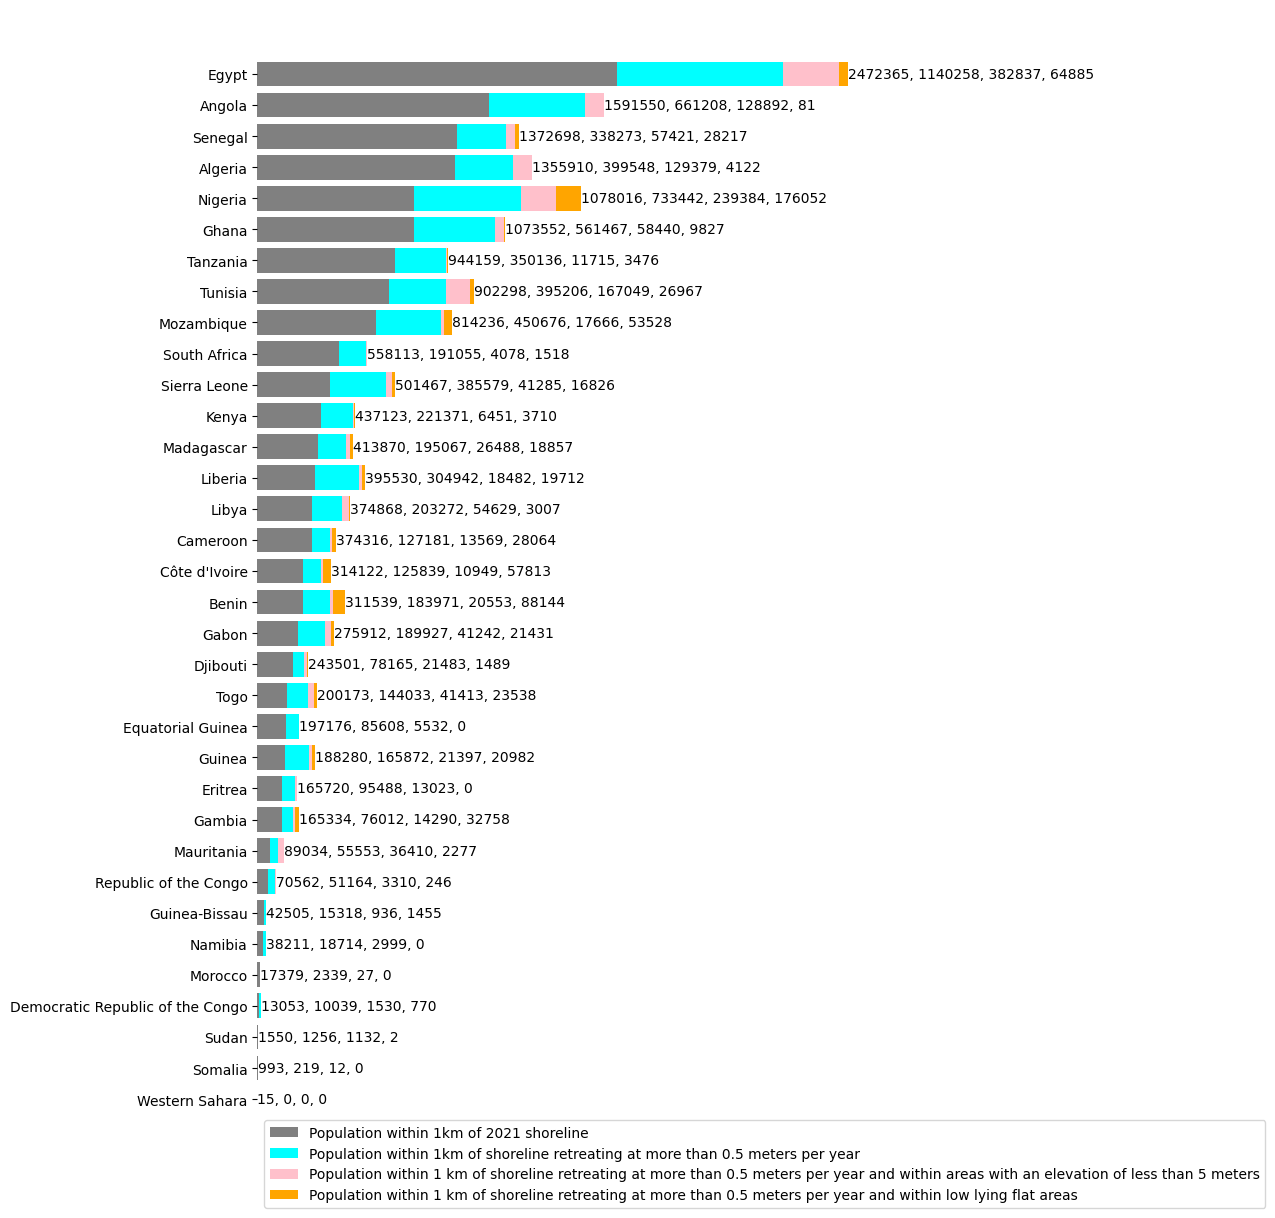

In [11]:
countries_sorted = countries_summary.sort_values(by='pop_nearshore')

countries = countries_sorted.Country.values
pop1_data = countries_sorted.pop_nearshore.values
pop2_data = countries_sorted.pop_nearerosion.values
pop3_data = countries_sorted.pop_lowelev.values
pop4_data = countries_sorted.pop_valley.values
# Set the color scheme for the segments
colors = ['grey', 'cyan', 'pink', 'orange']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
pop1_bars = ax.barh(indices, pop1_data, color=colors[0], label='Population within 1km of 2021 shoreline')
pop2_bars = ax.barh(indices, pop2_data, left=pop1_data, color=colors[1], label='Population within 1km of shoreline retreating at more than 0.5 meters per year')
pop3_bars = ax.barh(indices, pop3_data, left=pop1_data+pop2_data, color=colors[2], label='Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters')
pop4_bars = ax.barh(indices, pop4_data, left=pop1_data+pop2_data+pop3_data, color=colors[3], label='Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the right of each bar segment
for i in range(len(countries)):
    total_width = pop1_data[i] + pop2_data[i] + pop3_data[i] + pop4_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(pop1_data[i],1):.0f}, {round(pop2_data[i],1):.0f}, {round(pop3_data[i],1):.0f}, {round(pop4_data[i],1):.0f}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_pop_stack.png', bbox_inches='tight')

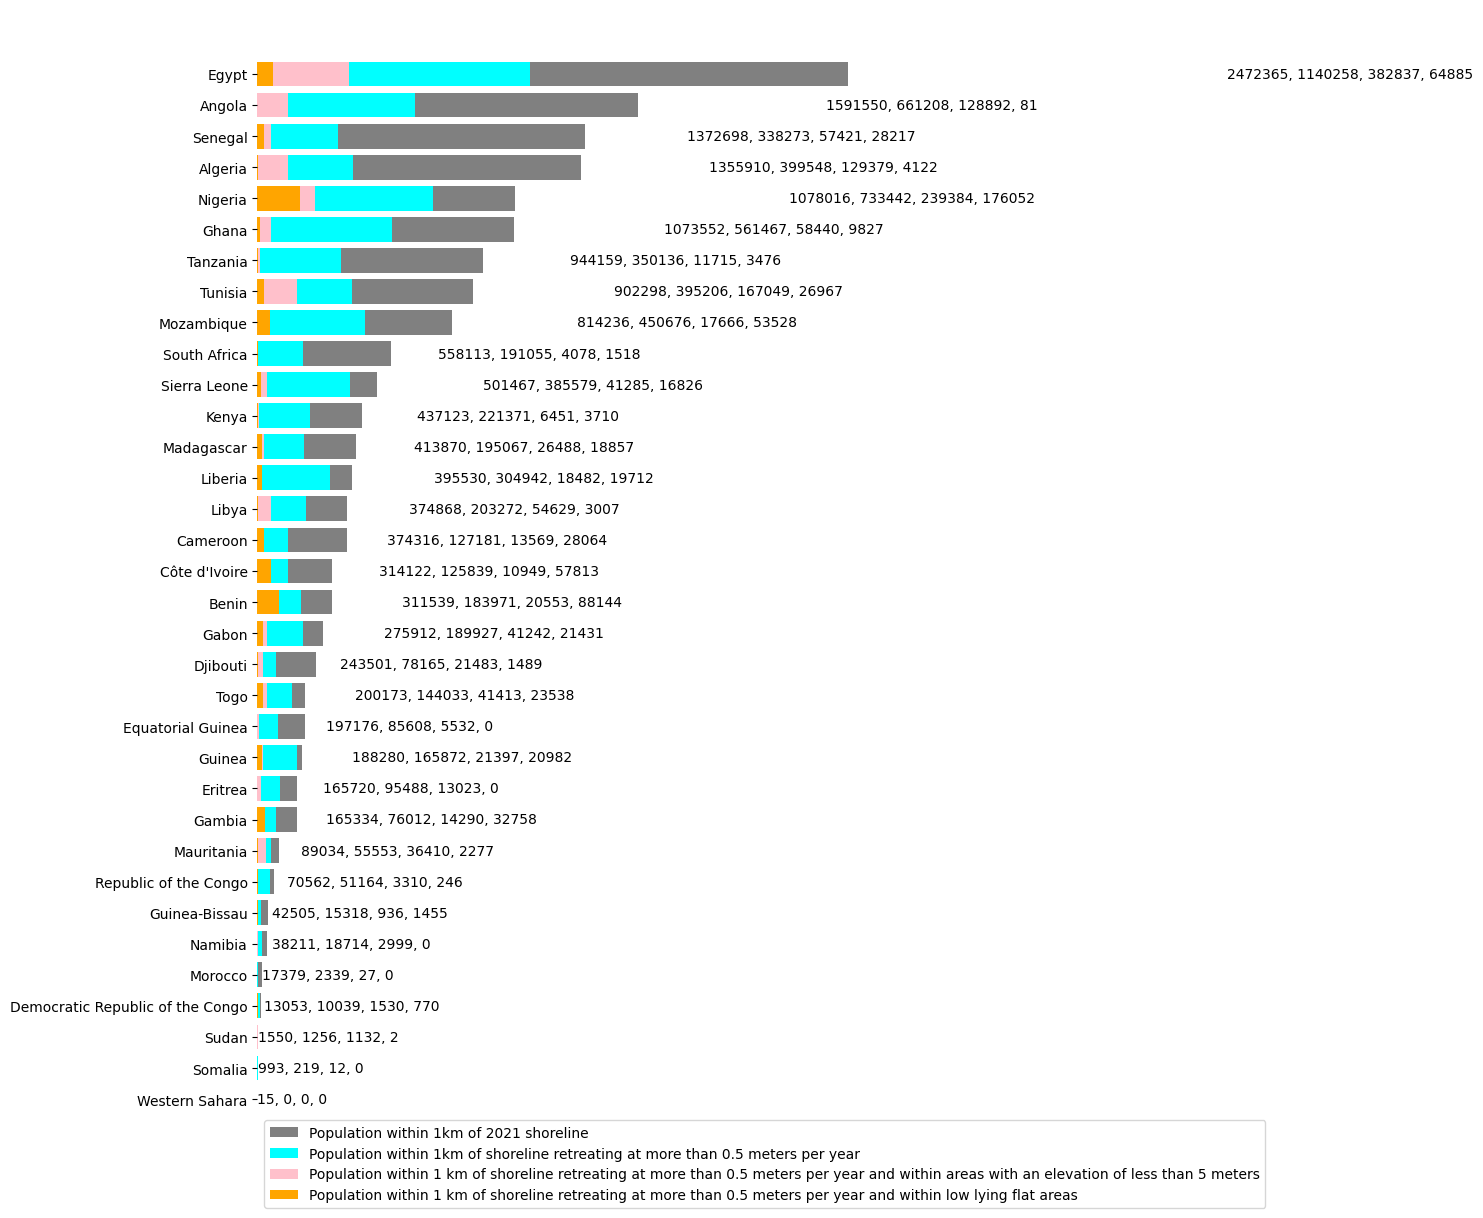

In [12]:
countries_sorted = countries_summary.sort_values(by='pop_nearshore')

countries = countries_sorted.Country.values
pop1_data = countries_sorted.pop_nearshore.values
pop2_data = countries_sorted.pop_nearerosion.values
pop3_data = countries_sorted.pop_lowelev.values
pop4_data = countries_sorted.pop_valley.values
# Set the color scheme for the segments
colors = ['grey', 'cyan', 'pink', 'orange']

# Create a list of indices for the bars
indices = np.arange(len(countries))

fig, ax = plt.subplots(figsize=(8,15))

# Plot the stacked horizontal bars
pop1_bars = ax.barh(indices, pop1_data, color=colors[0], label='Population within 1km of 2021 shoreline')
pop2_bars = ax.barh(indices, pop2_data, color=colors[1], label='Population within 1km of shoreline retreating at more than 0.5 meters per year')
pop3_bars = ax.barh(indices, pop3_data, color=colors[2], label='Population within 1 km of shoreline retreating at more than 0.5 meters per year and within areas with an elevation of less than 5 meters')
pop4_bars = ax.barh(indices, pop4_data, color=colors[3], label='Population within 1 km of shoreline retreating at more than 0.5 meters per year and within low lying flat areas')

# Remove spines and ticks
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

# Add data value text to the right of each bar segment
for i in range(len(countries)):
    total_width = pop1_data[i] + pop2_data[i] + pop3_data[i] + pop4_data[i]
    x_center = total_width
    y_center = indices[i]
    ax.text(x_center, y_center, f"{round(pop1_data[i],1):.0f}, {round(pop2_data[i],1):.0f}, {round(pop3_data[i],1):.0f}, {round(pop4_data[i],1):.0f}", ha='left', va='center')

# Set the y-axis ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(countries)

# Place the legend outside of the figure
ax.legend(loc='center left', bbox_to_anchor=(0, 0), ncol=1)

fig.savefig('countries_pop.png', bbox_inches='tight')